In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pwd
%cd /content/drive/MyDrive/LSTM project/LSTM_Project/sector_analysis(food drug)/2016-2019(before covid)

/content
/content/drive/MyDrive/LSTM project/LSTM_Project/sector_analysis(food drug)/2016-2019(before covid)


In [ ]:
# sector-> Food & Drug store(2016/01/01~2019/12/31) 
import pandas as pd
df1=pd.read_csv("SVNDY.csv") 
df2=pd.read_csv("WBA.csv")  
df3=pd.read_csv("MTRAF.csv")
df4=pd.read_csv("COOP.csv") 
df5=pd.read_csv("JSAIY.csv")  
df6=pd.read_csv("ADRNY.csv")  
df7=pd.read_csv("TSCDY.csv")  
df8=pd.read_csv("KR.csv")    
df9=pd.read_csv("AGHC.csv")  
df10=pd.read_csv("CRRFY.csv") 
df11=pd.read_csv("WNGRF.csv") 

print(df1.shape, df2.shape, df3.shape, df4.shape, df5.shape, df6.shape, df7.shape, df8.shape, df9.shape, df10.shape, df11.shape)
df1

(1006, 8) (1006, 8) (1006, 8) (1006, 8) (1006, 8) (1006, 8) (1006, 8) (1006, 8) (1006, 8) (1006, 8) (1006, 8)


,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume
0,0,2016-01-04,22.240000,22.809999,22.230000,22.790001,22.790001,385800
1,1,2016-01-05,22.610001,22.750000,22.480000,22.670000,22.670000,52600
2,2,2016-01-06,22.370001,22.520000,22.209999,22.389999,22.389999,66000
3,3,2016-01-07,22.350000,22.629999,22.150000,22.629999,22.629999,49900
4,4,2016-01-08,21.690001,22.030001,21.510000,21.570000,21.570000,69000
...,...,...,...,...,...,...,...,...
1001,1001,2019-12-24,18.150000,18.430000,18.150000,18.379999,18.379999,29000
1002,1002,2019-12-26,18.280001,18.370001,18.280001,18.299999,18.299999,50500
1003,1003,2019-12-27,18.690001,18.690001,18.280001,18.389999,18.389999,55100
1004,1004,2019-12-30,17.940001,18.290001,17.940001,18.230000,18.230000,70900


# Make models (train)

In [ ]:
from keras.layers import *
def make_models(c, nl, v, V=False, output_c=['High'], output_i=[2], outputs_company=1, train_size=754, time_step=60, epochs=30, units=50): 
  import warnings
  warnings.simplefilter('ignore')
  import math
  import seaborn as sns
  import matplotlib.pyplot as plt
  import keras
  import pandas as pd
  import numpy as np
  from keras.models import Sequential
  from keras.layers import Dense
  from keras.layers import LSTM
  from keras.layers import Dropout
  from sklearn.preprocessing import MinMaxScaler
  from sklearn.preprocessing import StandardScaler
  from sklearn.metrics import mean_squared_error
  from sklearn.metrics import mean_absolute_error
  from sklearn.model_selection import train_test_split
  from keras.callbacks import EarlyStopping
  """
  items={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6}
  v=[1, 2, 3, 4, 6]  
  output_c=['High']
  output_i=[2] 　"""
  
  print(f"[Arguments]") 
  print(f"num_company={len(nl)}社 {nl}")
  print(f"input_item={v}, outout_item={output_i}, output_category={output_c}")
  print(f"train_size={train_size}, time_step={time_step}, num_epoch={epochs}, num_units(neurons)={units}")
  print("")

  print("~~Make models~~")
  #1. split train and test data
  train_data=[]
  test_data=[]
  for i in range(len(c)):
    train_data.append(c[i].iloc[: train_size, v].values)
    test_data.append(c[i].iloc[train_size:, v].values)
  print(f"train_data={np.array(train_data).shape}, test_data={np.array(test_data).shape}")

  #2. train_data->normalise depending on number of inputs (only the volume is processed separately as the scale is different)
  #3. make X_train, y_train flexibly
  X_train=[]
  y_trains=[]
  
  if len(output_i) != 1:
    print("SECTOR1")
    # print(f"output>=2, inputs={v}, outputs={output_c}")
    training_set_others=np.hstack((data[:,:-1] for data in train_data))
    training_set_volume=np.hstack((data[:,-1:].reshape(-1, 1) for data in train_data))

    ss_others=[]
    for i in range(training_set_others.shape[1]):
      ss1=StandardScaler()
      ss_others.append(ss1.fit_transform(training_set_others[:,i].reshape(-1, 1)))
    ss_others=np.hstack(ss_others)

    ss2=StandardScaler()
    ss_v=ss2.fit_transform(training_set_volume)
    concat=np.hstack((ss_others, ss_v))
    # print(f"concat={concat.shape}")

    #ind=output用のvariablesのindexを抜き取る=>個別に学習モデルを作成するため
    if 6 in output_i: 
      print("SECTOR1-1")
      ind = []
      for i in range(len(output_i)):
        if output_i[i] != 6:
          ind+=[j for j in range(v.index(output_i[i]), len(c)*(len(v)-1), len(v)-1)] 
        else:
          ind+=[k for k in range(len(c)*(len(v)-1), len(c)*len(v))]
                              
      # print(f"len(ind)={len(ind)}, ind={ind}")
      for l in range(time_step, train_size):
        X_train.append(concat[l-time_step: l, :])
        for m in range(len(ind)):
          y_trains.append(concat[l, ind[m]])
      print(len(X_train), len(y_trains))

    else:
      print("SECTOR1-2")
      ind=[]
      for i in range(len(output_i)):
        ind+=[j for j in range(v.index(output_i[i]), len(c)*(len(v)), len(v))] 
      # print(f"num_of_companies={len(c)}, ind={ind}")
      
      for l in range(time_step, train_size):
        X_train.append(concat[l-time_step: l, :])
        for m in range(len(ind)):
          y_trains.append(concat[l, ind[m]])
      print(len(X_train), len(y_trains))

  else: #outputが１つの時
    print("SECTOR2")
    if V:
      print("SECTOR2-1")

      training_set_volume=np.hstack((data[:,-1].reshape(-1, 1) for data in train_data))
      ss2=StandardScaler()
      ss_v=ss2.fit_transform(training_set_volume)

      # print(f"concat={ss_v.shape}")

      ind = [id for id in range(len(c))]
      # print(f"num_of_companies={len(c)}, ind={ind}")

      for j in range(time_step, train_size):
        X_train.append(ss_v[j-time_step: j, :])
        for k in range(len(ind)):
          y_trains.append(ss_v[j, ind[k]])

    else: # volume含まれていない時
      print("SECTOR2-2")
      # from sklearn.preprocessing import MinMaxScaler#確認用
      # ss３=MinMaxScaler(feature_range=(0,1))

      training_set_all=np.hstack(np.array(train_data))
      ss2=StandardScaler()

      concat=ss2.fit_transform(training_set_all)

      ind = [id for id in range(len(c))]

      for j in range(time_step, train_size):
        X_train.append(concat[j-time_step: j, :])
        for k in range(len(ind)):
          y_trains.append(concat[j, ind[k]])

  X_train=np.array(X_train)
  y_trains=np.array(y_trains)
  print(f"X_train={X_train.shape}, y_trains={y_trains.shape}")
  # print("finish making X_train and y_trains")
  #3.train models(numbers of companies)

  y_trains2=[]
  
  if len(output_i) != 1:
    for x in range(len(c)*len(output_i)):
      x_tr=np.array([y_trains[i] for i in range(x, len(y_trains), len(c)*len(output_i))])
      y_trains2.append(x_tr)

  else: # len(output_i)==1
    for y in range(len(c)):
      y_tr=np.array([y_trains[i] for i in range(y, len(y_trains), len(c))])
      y_trains2.append(y_tr)

  y_trains2=np.array(y_trains2)
  print(f"y_trains2={y_trains2.shape}")

  model_lists = []
  
  for l in range(outputs_company):
    print(f"{l+1}/{outputs_company}")

    model = Sequential()

    model.add(LSTM(units = units, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2] )))
    model.add(Dropout(0.2))

    model.add(LSTM(units = units, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = units, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = units, return_sequences = False))
    model.add(Dropout(0.2))

    model.add(Dense(units = 1))

    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    model.fit(X_train, y_trains2[l], epochs=epochs, batch_size=32)
    model_lists.append(model)
    print("")
  return model_lists, y_trains2[:outputs_company]

# Make predictions (test)


In [ ]:
# Make predictions
def make_preds(c, nl, v, model_lists, y_trains2, V=False, output_c=['High'], output_i=[2], train_size=754, time_step=60):
  import warnings
  warnings.simplefilter('ignore')
  import math
  import seaborn as sns
  import matplotlib.pyplot as plt
  import keras
  import pandas as pd
  import numpy as np
  from keras.models import Sequential
  from keras.layers import Dense
  from keras.layers import LSTM
  from keras.layers import Dropout
  from sklearn.preprocessing import MinMaxScaler
  from sklearn.preprocessing import StandardScaler
  from sklearn.metrics import mean_squared_error
  from sklearn.metrics import mean_absolute_error
  from sklearn.model_selection import train_test_split
  from keras.callbacks import EarlyStopping
  
  print("~~Make predctions~~")
  #4. Prepare test data and normalise and make predictions
  train_data=[]
  test_data=[]
  for i in range(len(c)):
    train_data.append(c[i].iloc[: train_size, v].values)
    test_data.append(c[i].iloc[train_size:, v].values)
  print(f"train_data={np.array(train_data).shape}, test_data={np.array(test_data).shape}")

  inputs = []
  
  for m in range(len(c)): # ここではvで指定したvariablesだけのarrayに加工している
    inputs.append(c[m].iloc[:, v][len(c[m])-len(test_data[m])-time_step:].values)
  
  inputs = np.array(inputs)
  variables=[]
  ss=[]
  for i in range(len(c)):
    for j in range(len(v)): #11*5=55
      m=inputs[i, :, j].reshape(-1, 1) 
      s=StandardScaler()
      t=s.fit_transform(m)

      variables.append(t)
      ss.append(s)
  
  inputs2=np.hstack(variables)
  s1=StandardScaler()
  inputs2=s1.fit_transform(inputs2)
  
  X_test = []
  # use all components as imputs for testing
  for n in range(time_step, np.array(test_data).shape[1]+time_step):
    X_test.append(inputs2[n-time_step:n, :])

  X_test = np.array(X_test)
  preds = [] #(11, 252) (252, 1)
  for o in range(len(y_trains2)):
    preds.append(np.array(model_lists[o].predict(X_test)))
  
  if len(output_i)==1:
    ind=[i for i in range(v.index(output_i[0]), len(c)*len(v), len(v))]
  else:
    ind=[]
    for i in range(len(output_i)):
      ind+=[j for j in range(v.index(output_i[i]), len(c)*len(v), len(v))]

  for p in range(len(y_trains2)): #(252, 11)
    preds[p] = ss[ind[p]].inverse_transform(preds[p]) #修正必要
  preds = np.array(preds)

  #5. Plot actual vs preds
  # df ={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6] 
  actual_lists_test=[]
  actual_lists_train=[]
  for dd in range(len(output_i)):
    # for cc in range(len(c)):
    actual_lists_test+=[sc.iloc[train_size:,output_i[dd]] for sc in c]
    actual_lists_train+=[sc.iloc[:train_size,output_i[dd]] for sc in c]
  
  if len(output_i) > 1:
    R2=nl*len(output_i) # lists of companies
  else: R2=nl
  
  print(f"actual_lists_train={np.array(actual_lists_train).shape}, actual_lists_test={np.array(actual_lists_test).shape}, preds_list={np.array(preds).shape}")

  R=0
  r=[r for r in range(len(c)-1, len(R2), len(c))]
  print(f"[{output_c}]")
  
  plt.figure(figsize=(16, 10))
  for p in range(len(R2)):
    plt.subplot(2, 2, p+1) 
    plt.plot(c[0].loc[:train_size-1,'Date'], actual_lists_train[p], color='black', label='Real(Trainning)')
    plt.plot(c[0].loc[train_size:,'Date'], actual_lists_test[p], color='red', label='Real(Test)')
    plt.plot(c[0].loc[train_size:,'Date'], preds[p], color='blue', label='Predict')
    plt.xticks(np.arange(0, 1006, 251))
    plt.xlabel('Date')
    plt.ylabel('High Price($)')
    
    from sklearn.metrics import r2_score
    plt.title(f"R2: {R2[p]}={round(r2_score(actual_lists_test[p], preds[p].flatten()), 4)}")

    R +=r2_score(actual_lists_test[p], preds[p].flatten())
    plt.legend()
  plt.show()

  if p in r:
    print(f"R2-{len(c)}companies_average={round(R/len(c), 4)}")
    R=0
    print("")

  #6. Make confusion matrix

  # columns = nl # labeling 
  # Actual 
  # print("Actual")
  # act=[a for a in actual_lists]
  # Actual=pd.concat(act, axis=1)
  # Actual.columns = columns
  # plt.figure(figsize=(12, 10))
  # cmap=sns.diverging_palette(220, 20, as_cmap=True)
  # sns.heatmap(Actual.corr(method='spearman'), cmap=cmap, annot=True) 

  # Predictions
  # for p in range(len(output_i)):
  #   print(f"Preds_Heatmap={output_c[p]} correlation")
  #   prd=[preds[p] for p in range(len(c)*p, len(c)+p*len(c))]
  #   # print(len(prd))
  #   Preds= pd.DataFrame(np.concatenate(prd, axis=1))
  #   Preds.columns = columns
  #   # print(Preds.columns)
  #   plt.figure(figsize=(8, 6))
  #   cmap=sns.diverging_palette(220, 20, as_cmap=True)
  #   sns.heatmap(Preds.corr(method='spearman'), cmap=cmap, annot=True) 

  # return preds[p].flatten()

  """Metro can be a special case, but the ohter companies in the same sector would have a sort of similarity. """

# 6月22日以降　


## ALL in ALL Function

In [ ]:
all_data=[df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11]
items={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6}
import random

def all_in_all(original_all_data, num_company=11, input_num=[2], output_category=['High'], output_num=[2], outputs_company=11, 
               train_size=754, time_step=60, epochs=20, units=50):

  all_companies_list=["Seven & I Holdings (Japan)", "Walgreens Boots Alliance (USA)", "Metro (Canada)", 'Coop Group (Switzerland)', 'J.Sainsbury(Britain)',
    "Royal Ahold Delhaize(Netherlands)", "Tesco(Britain)", "Kroger(USA)", "AEON(Japan)", "Carrefour(France)", "George Weston(Canada)"]

  # Pick up companies rondomly
  company_list=random.sample(all_companies_list, num_company) 
  
  all_data=[]
  for d in range(num_company):
    ind = all_companies_list.index(company_list[d])
    all_data.append(original_all_data[ind])

  if 6 not in input_num: Volume=False
  else: Volume=True

  # Make Models
  model_lists, y_trains = make_models(all_data, company_list, input_num, Volume, output_category, 
                                      output_num, outputs_company, train_size, time_step, epochs, units)
  # Make Predictions               
  make_preds(all_data, company_list, input_num, model_lists, y_trains, Volume, output_category, output_num, train_size, time_step)

In [ ]:
# データ集計 Box Plot作成
R2_2_lists=[('Seven & I Holdings (Japan)', 'Tesco(Britain)'), ('Metro (Canada)', 'AEON(Japan)'), ('J.Sainsbury(Britain)', 'Carrefour(France)'), ('Kroger(USA)', 'George Weston(Canada)'), 
            ('Carrefour(France)', 'Metro (Canada)'), ('Walgreens Boots Alliance (USA)', 'Kroger(USA)'), ('Metro (Canada)', 'Kroger(USA)'), ('Metro (Canada)', 'Kroger(USA)'), ('Metro (Canada)', 'J.Sainsbury(Britain)'), ('Tesco(Britain)', 'Metro (Canada)')]
R2_2=[(0.9501, 0.6941), (0.9545, 0.8508), (0.8968, 0.9454), (0.9087, 0.929), (0.8993, 0.9245), (0.9681, 09435), (0.955, 0.9494), (0.9676, 0.9316), (0.935, 0.7436), (0.53, 0.971)]
R2_ave=[0.8221, 0.9051, 09211, 0.9188, 0.9119, 0.9558, 0.9522, 0.9461, 0.8393, 0.7505]

R2_3_lists=[('J.Sainsbury(Britain)', 'George Weston(Canada)', 'Kroger(USA)'), ('George Weston(Canada)', 'J.Sainsbury(Britain)', 'Metro (Canada)'), ('Kroger(USA)', 'Coop Group (Switzerland)', 'Walgreens Boots Alliance (USA)')]
R2_3=[(0.2309, 0.8804, 0.8089), (0.7952, 0.2599, 0.9214), (0.8956, 0.7413, 0.7891)]
R2_ave=[0.6401, 0.6588, 0.8087]

## 流れ
### 1. Randomで会社を選定
### 2. Trainningデータも同時に表示
### 3. Subprot表示に対応(4✖︎2構成)

[Arguments]
num_company=2社 ['Seven & I Holdings (Japan)', 'Tesco(Britain)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(2, 754, 1), test_data=(2, 252, 1)
SECTOR2
SECTOR2-2
X_train=(694, 60, 2), y_trains=(1388,)
y_trains2=(2, 694)
1/2
Epoch 1/50
22/22 [==============================] - 13s 220ms/step - loss: 0.6407
Epoch 2/50
22/22 [==============================] - 5s 218ms/step - loss: 0.3788
Epoch 3/50
22/22 [==============================] - 5s 218ms/step - loss: 0.3557
Epoch 4/50
22/22 [==============================] - 5s 219ms/step - loss: 0.3347
Epoch 5/50
22/22 [==============================] - 5s 214ms/step - loss: 0.2953
Epoch 6/50
22/22 [==============================] - 5s 219ms/step - loss: 0.2632
Epoch 7/50
22/22 [==============================] - 5s 218ms/step - loss: 0.2381
Epoch 8/50
22/22 [==============================] - 5s 221ms/step - loss: 0.2306
Epoch 9

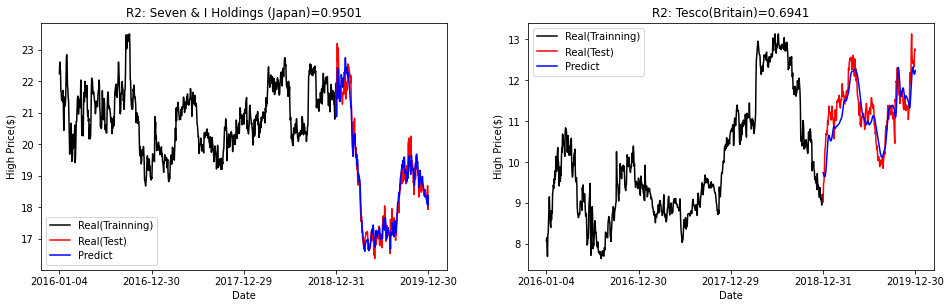

R2-2companies_average=0.8221091373730683

[Arguments]
num_company=2社 ['Metro (Canada)', 'AEON(Japan)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(2, 754, 1), test_data=(2, 252, 1)
SECTOR2
SECTOR2-2
X_train=(694, 60, 2), y_trains=(1388,)
y_trains2=(2, 694)
1/2
Epoch 1/50
22/22 [==============================] - 13s 220ms/step - loss: 0.5336
Epoch 2/50
22/22 [==============================] - 5s 219ms/step - loss: 0.2373
Epoch 3/50
22/22 [==============================] - 5s 217ms/step - loss: 0.2119
Epoch 4/50
22/22 [==============================] - 5s 217ms/step - loss: 0.1538
Epoch 5/50
22/22 [==============================] - 5s 219ms/step - loss: 0.1632
Epoch 6/50
22/22 [==============================] - 5s 219ms/step - loss: 0.1439
Epoch 7/50
22/22 [==============================] - 5s 218ms/step - loss: 0.1350
Epoch 8/50
22/22 [==============================] - 5s 219ms/

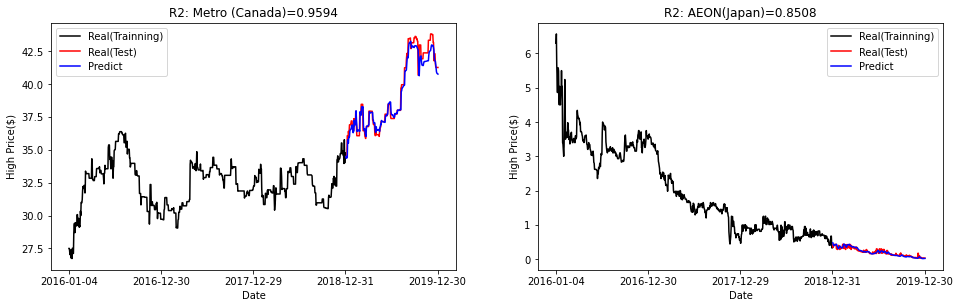

R2-2companies_average=0.9051014969213196

[Arguments]
num_company=2社 ['J.Sainsbury(Britain)', 'Carrefour(France)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(2, 754, 1), test_data=(2, 252, 1)
SECTOR2
SECTOR2-2
X_train=(694, 60, 2), y_trains=(1388,)
y_trains2=(2, 694)
1/2
Epoch 1/50
22/22 [==============================] - 12s 219ms/step - loss: 0.5880
Epoch 2/50
22/22 [==============================] - 5s 215ms/step - loss: 0.1575
Epoch 3/50
22/22 [==============================] - 5s 219ms/step - loss: 0.1388
Epoch 4/50
22/22 [==============================] - 5s 216ms/step - loss: 0.1190
Epoch 5/50
22/22 [==============================] - 5s 217ms/step - loss: 0.1199
Epoch 6/50
22/22 [==============================] - 5s 220ms/step - loss: 0.1048
Epoch 7/50
22/22 [==============================] - 5s 223ms/step - loss: 0.0969
Epoch 8/50
22/22 [==============================]

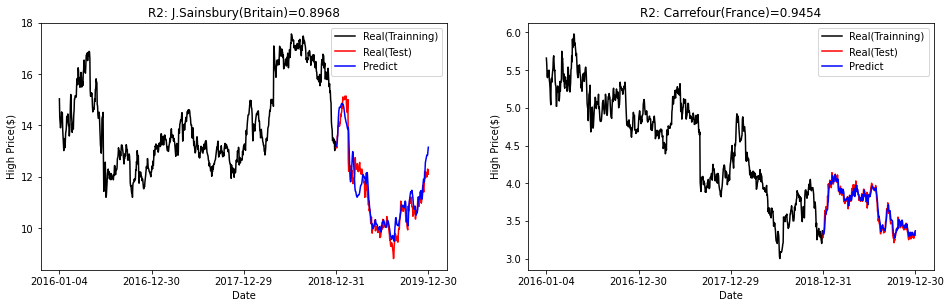

R2-2companies_average=0.9211060114124406

[Arguments]
num_company=2社 ['Kroger(USA)', 'George Weston(Canada)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(2, 754, 1), test_data=(2, 252, 1)
SECTOR2
SECTOR2-2
X_train=(694, 60, 2), y_trains=(1388,)
y_trains2=(2, 694)
1/2
Epoch 1/50
22/22 [==============================] - 13s 224ms/step - loss: 0.3577
Epoch 2/50
22/22 [==============================] - 5s 220ms/step - loss: 0.1201
Epoch 3/50
22/22 [==============================] - 5s 223ms/step - loss: 0.0981
Epoch 4/50
22/22 [==============================] - 5s 220ms/step - loss: 0.0845
Epoch 5/50
22/22 [==============================] - 5s 224ms/step - loss: 0.0786
Epoch 6/50
22/22 [==============================] - 5s 220ms/step - loss: 0.0644
Epoch 7/50
22/22 [==============================] - 5s 223ms/step - loss: 0.0652
Epoch 8/50
22/22 [==============================] - 5s

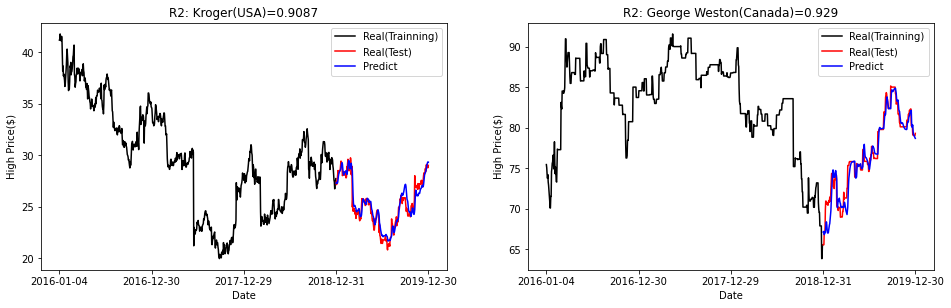

R2-2companies_average=0.9188458612066271

[Arguments]
num_company=2社 ['Carrefour(France)', 'Metro (Canada)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(2, 754, 1), test_data=(2, 252, 1)
SECTOR2
SECTOR2-2
X_train=(694, 60, 2), y_trains=(1388,)
y_trains2=(2, 694)
1/2
Epoch 1/50
22/22 [==============================] - 13s 221ms/step - loss: 0.3644
Epoch 2/50
22/22 [==============================] - 5s 223ms/step - loss: 0.1292
Epoch 3/50
22/22 [==============================] - 5s 220ms/step - loss: 0.0864
Epoch 4/50
22/22 [==============================] - 5s 223ms/step - loss: 0.0798
Epoch 5/50
22/22 [==============================] - 5s 221ms/step - loss: 0.0787
Epoch 6/50
22/22 [==============================] - 5s 224ms/step - loss: 0.0752
Epoch 7/50
22/22 [==============================] - 5s 221ms/step - loss: 0.0730
Epoch 8/50
22/22 [==============================] - 5s 

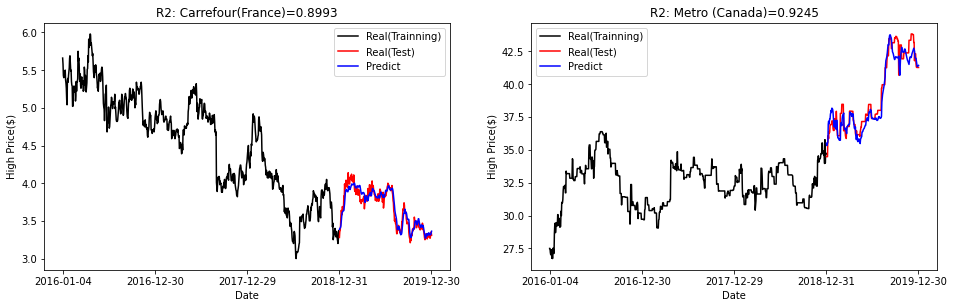

R2-2companies_average=0.9118900747925058

[Arguments]
num_company=2社 ['Walgreens Boots Alliance (USA)', 'Kroger(USA)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(2, 754, 1), test_data=(2, 252, 1)
SECTOR2
SECTOR2-2
X_train=(694, 60, 2), y_trains=(1388,)
y_trains2=(2, 694)
1/2
Epoch 1/50
22/22 [==============================] - 12s 221ms/step - loss: 0.3677
Epoch 2/50
22/22 [==============================] - 5s 221ms/step - loss: 0.1809
Epoch 3/50
22/22 [==============================] - 5s 221ms/step - loss: 0.1589
Epoch 4/50
22/22 [==============================] - 5s 218ms/step - loss: 0.1453
Epoch 5/50
22/22 [==============================] - 5s 220ms/step - loss: 0.1211
Epoch 6/50
22/22 [==============================] - 5s 222ms/step - loss: 0.1126
Epoch 7/50
22/22 [==============================] - 5s 221ms/step - loss: 0.0943
Epoch 8/50
22/22 [===========================

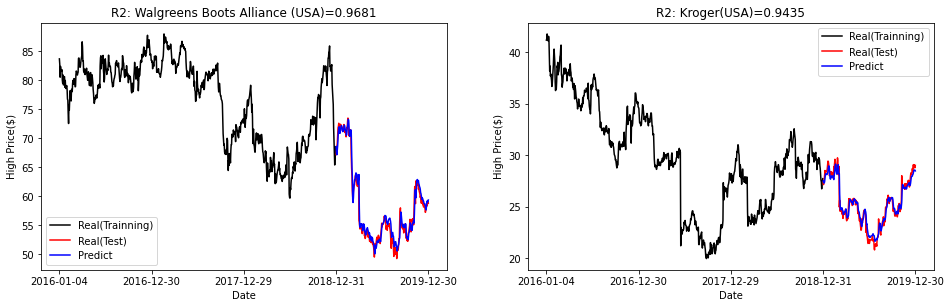

R2-2companies_average=0.9558016377895233

[Arguments]
num_company=2社 ['Metro (Canada)', 'Kroger(USA)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(2, 754, 1), test_data=(2, 252, 1)
SECTOR2
SECTOR2-2
X_train=(694, 60, 2), y_trains=(1388,)
y_trains2=(2, 694)
1/2
Epoch 1/50
22/22 [==============================] - 13s 230ms/step - loss: 0.5001
Epoch 2/50
22/22 [==============================] - 5s 226ms/step - loss: 0.2205
Epoch 3/50
22/22 [==============================] - 5s 223ms/step - loss: 0.2052
Epoch 4/50
22/22 [==============================] - 5s 225ms/step - loss: 0.1808
Epoch 5/50
22/22 [==============================] - 5s 227ms/step - loss: 0.1527
Epoch 6/50
22/22 [==============================] - 5s 225ms/step - loss: 0.1555
Epoch 7/50
22/22 [==============================] - 5s 224ms/step - loss: 0.1449
Epoch 8/50
22/22 [==============================] - 5s 223ms/

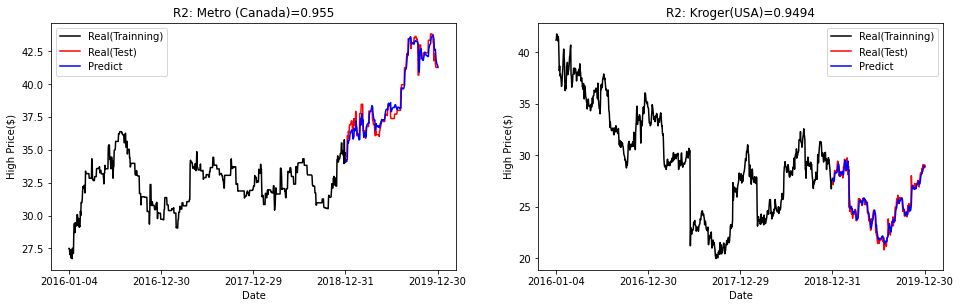

R2-2companies_average=0.9521913765401663

[Arguments]
num_company=2社 ['Seven & I Holdings (Japan)', 'Coop Group (Switzerland)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(2, 754, 1), test_data=(2, 252, 1)
SECTOR2
SECTOR2-2
X_train=(694, 60, 2), y_trains=(1388,)
y_trains2=(2, 694)
1/2
Epoch 1/50
22/22 [==============================] - 12s 225ms/step - loss: 0.6201
Epoch 2/50
22/22 [==============================] - 5s 226ms/step - loss: 0.3678
Epoch 3/50
22/22 [==============================] - 5s 224ms/step - loss: 0.3507
Epoch 4/50
22/22 [==============================] - 5s 224ms/step - loss: 0.3097
Epoch 5/50
22/22 [==============================] - 5s 226ms/step - loss: 0.2764
Epoch 6/50
22/22 [==============================] - 5s 227ms/step - loss: 0.2207
Epoch 7/50
22/22 [==============================] - 5s 223ms/step - loss: 0.2285
Epoch 8/50
22/22 [==================

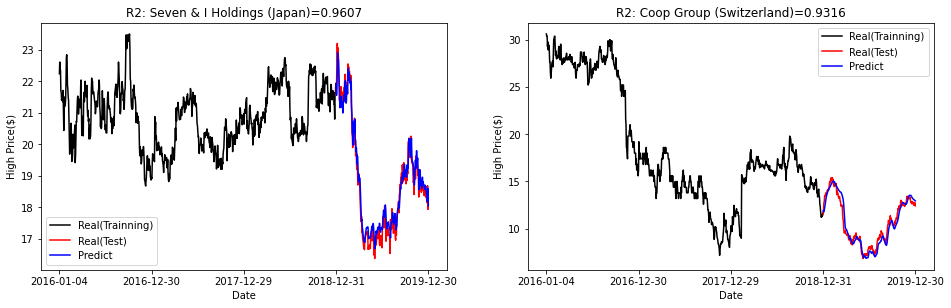

R2-2companies_average=0.94613415755247

[Arguments]
num_company=2社 ['Metro (Canada)', 'J.Sainsbury(Britain)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(2, 754, 1), test_data=(2, 252, 1)
SECTOR2
SECTOR2-2
X_train=(694, 60, 2), y_trains=(1388,)
y_trains2=(2, 694)
1/2
Epoch 1/50
22/22 [==============================] - 12s 223ms/step - loss: 0.4735
Epoch 2/50
22/22 [==============================] - 5s 225ms/step - loss: 0.2190
Epoch 3/50
22/22 [==============================] - 5s 223ms/step - loss: 0.1925
Epoch 4/50
22/22 [==============================] - 5s 223ms/step - loss: 0.1468
Epoch 5/50
22/22 [==============================] - 5s 227ms/step - loss: 0.1491
Epoch 6/50
22/22 [==============================] - 5s 225ms/step - loss: 0.1329
Epoch 7/50
22/22 [==============================] - 5s 224ms/step - loss: 0.1389
Epoch 8/50
22/22 [==============================] - 5s

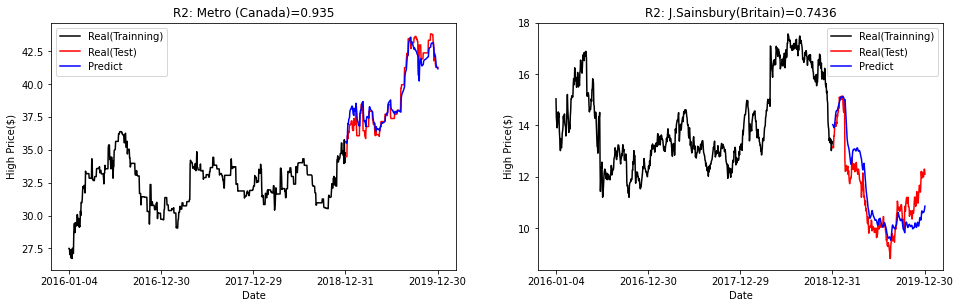

R2-2companies_average=0.8393053590075545

[Arguments]
num_company=2社 ['Tesco(Britain)', 'Metro (Canada)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(2, 754, 1), test_data=(2, 252, 1)
SECTOR2
SECTOR2-2
X_train=(694, 60, 2), y_trains=(1388,)
y_trains2=(2, 694)
1/2
Epoch 1/50
22/22 [==============================] - 13s 228ms/step - loss: 0.4666
Epoch 2/50
22/22 [==============================] - 5s 226ms/step - loss: 0.1151
Epoch 3/50
22/22 [==============================] - 5s 229ms/step - loss: 0.1042
Epoch 4/50
22/22 [==============================] - 5s 226ms/step - loss: 0.0884
Epoch 5/50
22/22 [==============================] - 5s 225ms/step - loss: 0.0878
Epoch 6/50
22/22 [==============================] - 5s 224ms/step - loss: 0.0754
Epoch 7/50
22/22 [==============================] - 5s 225ms/step - loss: 0.0682
Epoch 8/50
22/22 [==============================] - 5s 225

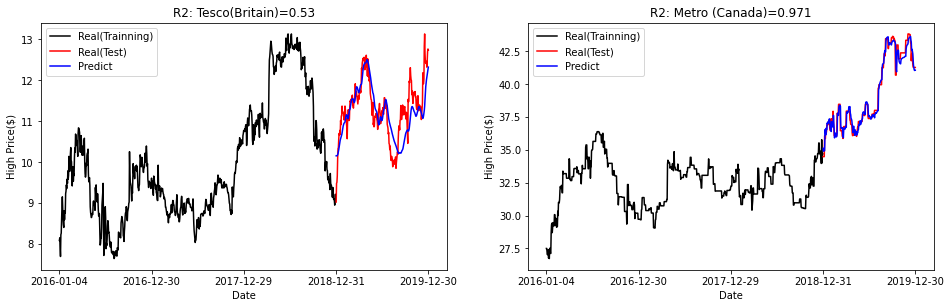

R2-2companies_average=0.7504613704681675



In [ ]:
# time_step=60, epochs=50, units=100
for i in range(10):
  all_in_all(all_data, num_company=2, input_num=[2], output_category=['High'], output_num=[2], outputs_company=2,
           train_size=754, time_step=60, epochs=50, units=100)

[Arguments]
num_company=3社 ['J.Sainsbury(Britain)', 'George Weston(Canada)', 'Kroger(USA)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(3, 754, 1), test_data=(3, 252, 1)
SECTOR2
SECTOR2-2
X_train=(694, 60, 3), y_trains=(2082,)
y_trains2=(3, 694)
1/3
Epoch 1/50
22/22 [==============================] - 13s 221ms/step - loss: 0.4378
Epoch 2/50
22/22 [==============================] - 5s 221ms/step - loss: 0.1376
Epoch 3/50
22/22 [==============================] - 5s 220ms/step - loss: 0.1206
Epoch 4/50
22/22 [==============================] - 5s 220ms/step - loss: 0.1071
Epoch 5/50
22/22 [==============================] - 5s 218ms/step - loss: 0.0891
Epoch 6/50
22/22 [==============================] - 5s 219ms/step - loss: 0.0838
Epoch 7/50
22/22 [==============================] - 5s 221ms/step - loss: 0.0877
Epoch 8/50
22/22 [==============================] - 5s 218ms/step - loss

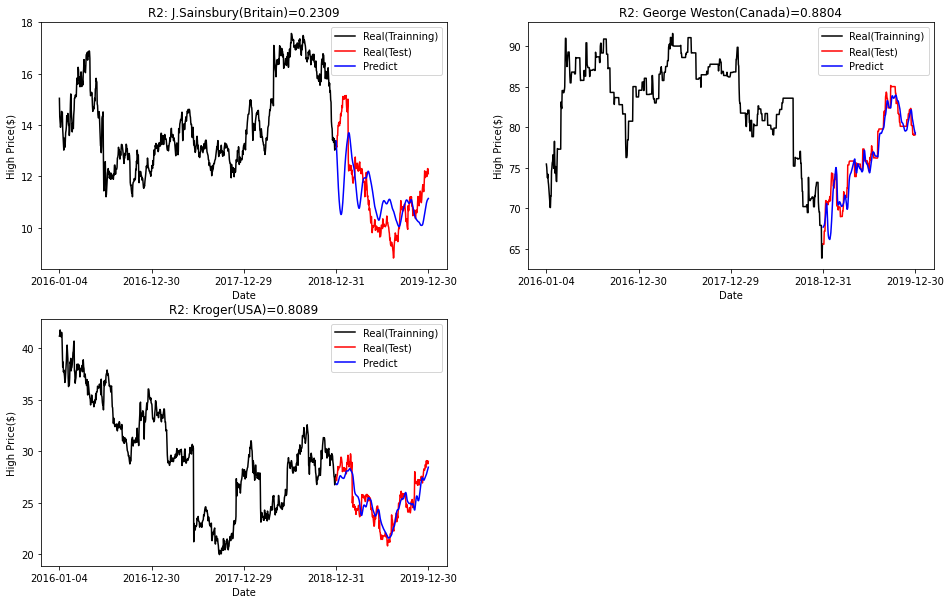

R2-3companies_average=0.6401

[Arguments]
num_company=3社 ['George Weston(Canada)', 'J.Sainsbury(Britain)', 'Metro (Canada)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(3, 754, 1), test_data=(3, 252, 1)
SECTOR2
SECTOR2-2
X_train=(694, 60, 3), y_trains=(2082,)
y_trains2=(3, 694)
1/3
Epoch 1/50
22/22 [==============================] - 14s 219ms/step - loss: 0.3609
Epoch 2/50
22/22 [==============================] - 5s 221ms/step - loss: 0.1261
Epoch 3/50
22/22 [==============================] - 5s 222ms/step - loss: 0.1166
Epoch 4/50
22/22 [==============================] - 5s 218ms/step - loss: 0.1279
Epoch 5/50
22/22 [==============================] - 5s 218ms/step - loss: 0.0930
Epoch 6/50
22/22 [==============================] - 5s 220ms/step - loss: 0.0690
Epoch 7/50
22/22 [==============================] - 5s 219ms/step - loss: 0.0754
Epoch 8/50
22/22 [=====================

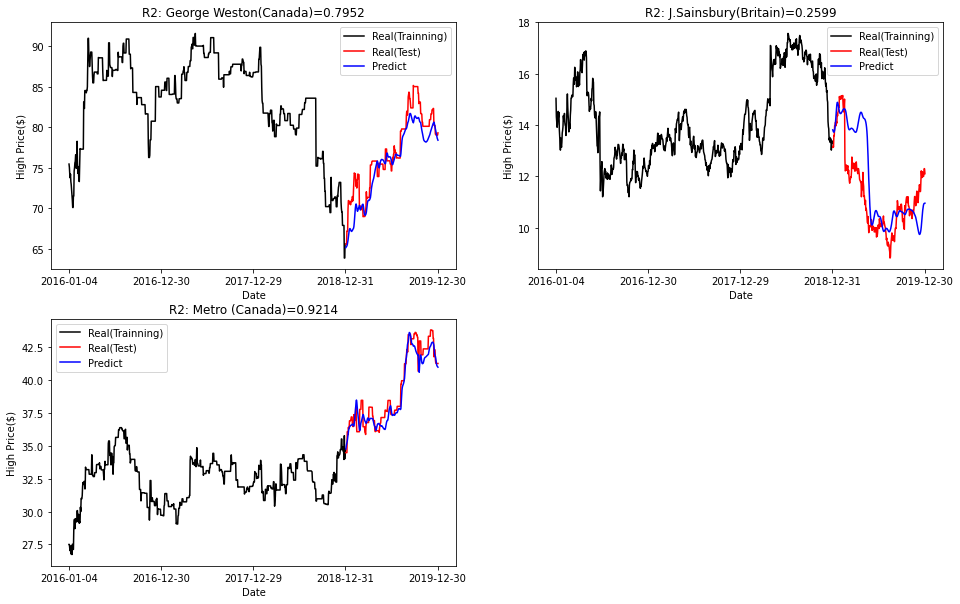

R2-3companies_average=0.6588

[Arguments]
num_company=3社 ['Kroger(USA)', 'Coop Group (Switzerland)', 'Walgreens Boots Alliance (USA)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(3, 754, 1), test_data=(3, 252, 1)
SECTOR2
SECTOR2-2
X_train=(694, 60, 3), y_trains=(2082,)
y_trains2=(3, 694)
1/3
Epoch 1/50
22/22 [==============================] - 12s 222ms/step - loss: 0.3998
Epoch 2/50
22/22 [==============================] - 5s 218ms/step - loss: 0.1236
Epoch 3/50
22/22 [==============================] - 5s 219ms/step - loss: 0.0892
Epoch 4/50
22/22 [==============================] - 5s 217ms/step - loss: 0.0771
Epoch 5/50
22/22 [==============================] - 5s 218ms/step - loss: 0.0692
Epoch 6/50
22/22 [==============================] - 5s 217ms/step - loss: 0.0697
Epoch 7/50
22/22 [==============================] - 5s 219ms/step - loss: 0.0610
Epoch 8/50
22/22 [===========

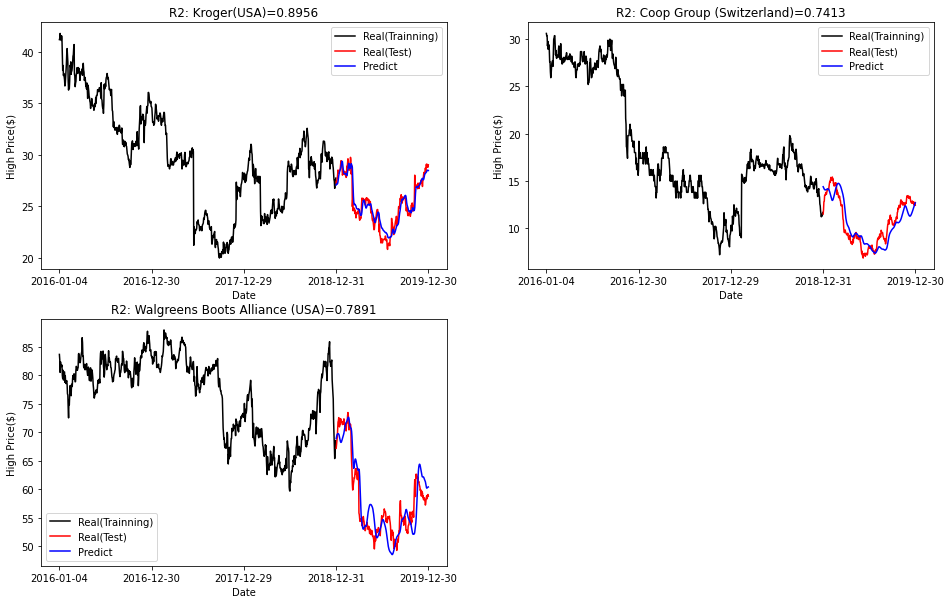

R2-3companies_average=0.8087

[Arguments]
num_company=3社 ['J.Sainsbury(Britain)', 'Royal Ahold Delhaize(Netherlands)', 'Coop Group (Switzerland)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(3, 754, 1), test_data=(3, 252, 1)
SECTOR2
SECTOR2-2
X_train=(694, 60, 3), y_trains=(2082,)
y_trains2=(3, 694)
1/3
Epoch 1/50
22/22 [==============================] - 12s 214ms/step - loss: 0.5272
Epoch 2/50
22/22 [==============================] - 5s 215ms/step - loss: 0.1807
Epoch 3/50
22/22 [==============================] - 5s 225ms/step - loss: 0.1252
Epoch 4/50
22/22 [==============================] - 5s 226ms/step - loss: 0.1222
Epoch 5/50
22/22 [==============================] - 5s 223ms/step - loss: 0.0987
Epoch 6/50
22/22 [==============================] - 5s 222ms/step - loss: 0.0812
Epoch 7/50
22/22 [==============================] - 5s 220ms/step - loss: 0.1031
Epoch 8/50
22/22 

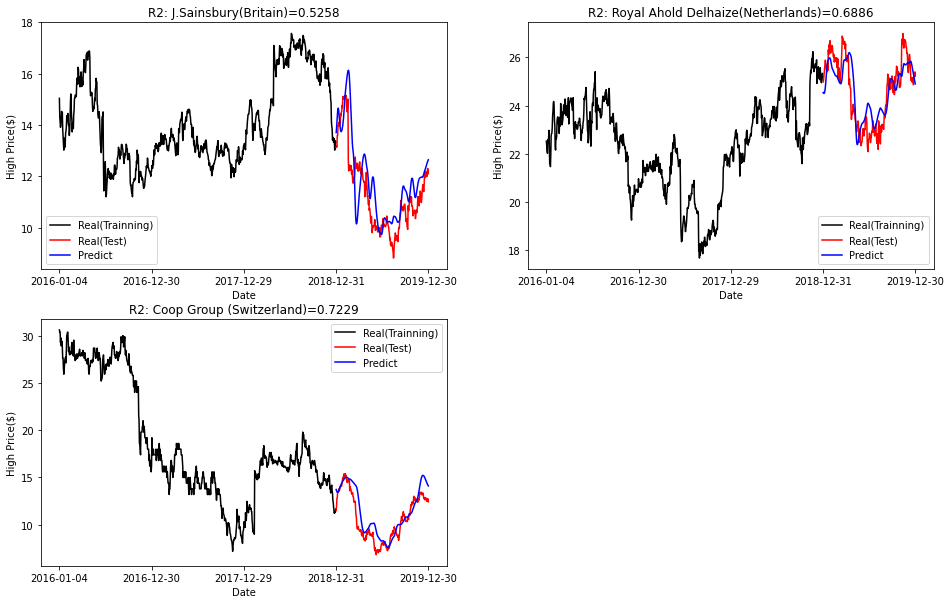

R2-3companies_average=0.6457

[Arguments]
num_company=3社 ['Royal Ahold Delhaize(Netherlands)', 'Metro (Canada)', 'Tesco(Britain)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(3, 754, 1), test_data=(3, 252, 1)
SECTOR2
SECTOR2-2
X_train=(694, 60, 3), y_trains=(2082,)
y_trains2=(3, 694)
1/3
Epoch 1/50
22/22 [==============================] - 12s 213ms/step - loss: 0.5701
Epoch 2/50
22/22 [==============================] - 5s 212ms/step - loss: 0.2310
Epoch 3/50
22/22 [==============================] - 5s 214ms/step - loss: 0.1719
Epoch 4/50
22/22 [==============================] - 5s 214ms/step - loss: 0.1171
Epoch 5/50
22/22 [==============================] - 5s 211ms/step - loss: 0.1127
Epoch 6/50
22/22 [==============================] - 5s 212ms/step - loss: 0.0941
Epoch 7/50
22/22 [==============================] - 5s 211ms/step - loss: 0.0760
Epoch 8/50
22/22 [===============

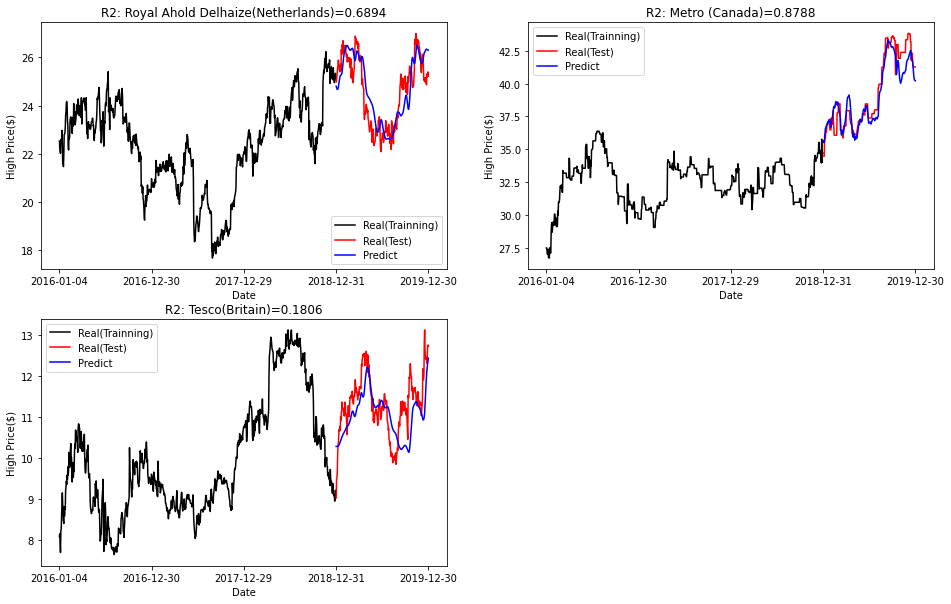

R2-3companies_average=0.5829

[Arguments]
num_company=3社 ['Carrefour(France)', 'J.Sainsbury(Britain)', 'George Weston(Canada)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(3, 754, 1), test_data=(3, 252, 1)
SECTOR2
SECTOR2-2
X_train=(694, 60, 3), y_trains=(2082,)
y_trains2=(3, 694)
1/3
Epoch 1/50
22/22 [==============================] - 13s 216ms/step - loss: 0.4067
Epoch 2/50
22/22 [==============================] - 5s 216ms/step - loss: 0.1215
Epoch 3/50
22/22 [==============================] - 5s 216ms/step - loss: 0.0828
Epoch 4/50
22/22 [==============================] - 5s 216ms/step - loss: 0.0848
Epoch 5/50
22/22 [==============================] - 5s 216ms/step - loss: 0.0767
Epoch 6/50
22/22 [==============================] - 5s 217ms/step - loss: 0.0717
Epoch 7/50
22/22 [==============================] - 5s 219ms/step - loss: 0.0665
Epoch 8/50
22/22 [==================

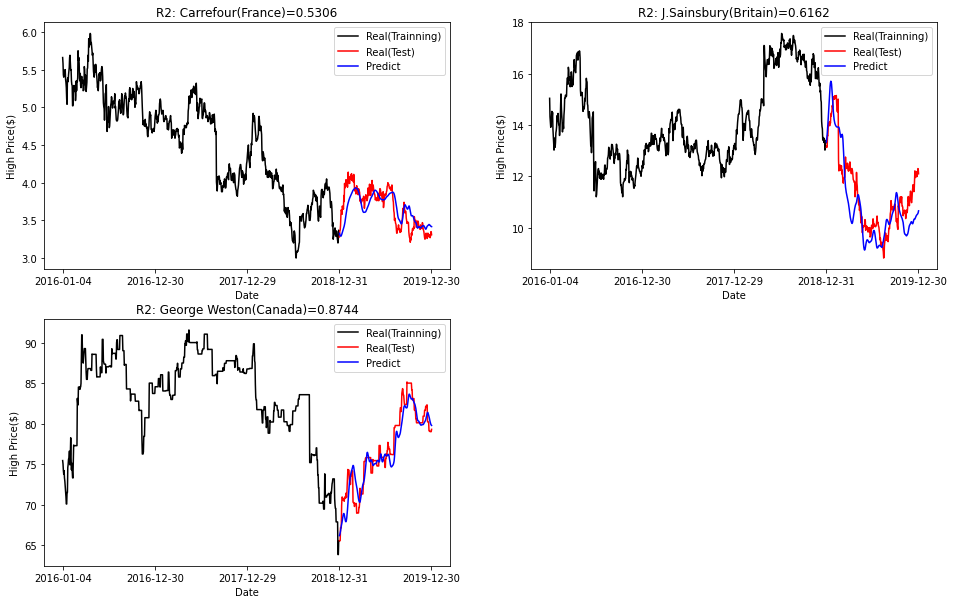

R2-3companies_average=0.6737

[Arguments]
num_company=3社 ['Kroger(USA)', 'Royal Ahold Delhaize(Netherlands)', 'Carrefour(France)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(3, 754, 1), test_data=(3, 252, 1)
SECTOR2
SECTOR2-2
X_train=(694, 60, 3), y_trains=(2082,)
y_trains2=(3, 694)
1/3
Epoch 1/50
22/22 [==============================] - 12s 217ms/step - loss: 0.3500
Epoch 2/50
22/22 [==============================] - 5s 216ms/step - loss: 0.1053
Epoch 3/50
22/22 [==============================] - 5s 216ms/step - loss: 0.0964
Epoch 4/50
22/22 [==============================] - 5s 213ms/step - loss: 0.0862
Epoch 5/50
22/22 [==============================] - 5s 214ms/step - loss: 0.0757
Epoch 6/50
22/22 [==============================] - 5s 214ms/step - loss: 0.0581
Epoch 7/50
22/22 [==============================] - 5s 214ms/step - loss: 0.0592
Epoch 8/50
22/22 [===============

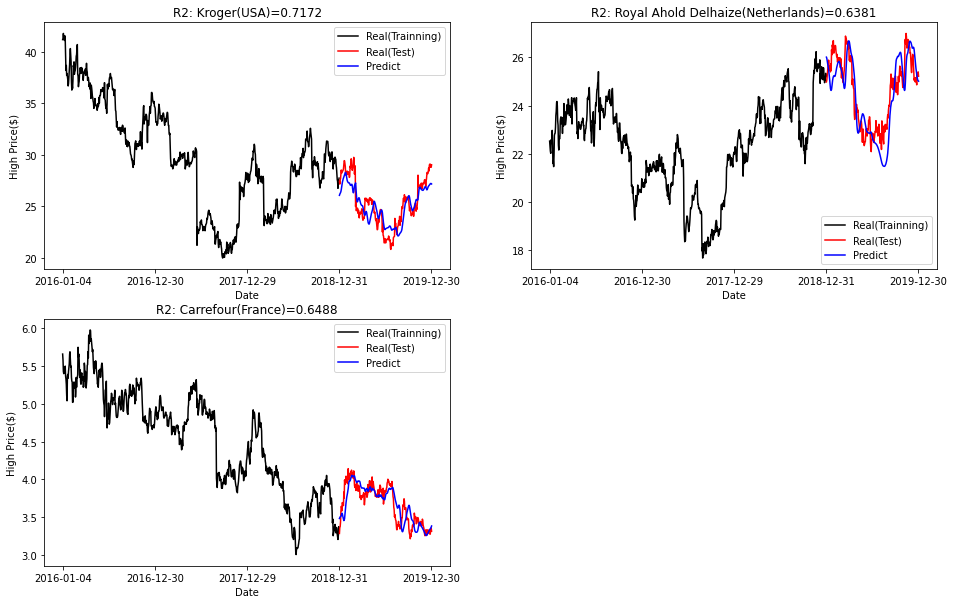

R2-3companies_average=0.668

[Arguments]
num_company=3社 ['Metro (Canada)', 'J.Sainsbury(Britain)', 'Kroger(USA)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(3, 754, 1), test_data=(3, 252, 1)
SECTOR2
SECTOR2-2
X_train=(694, 60, 3), y_trains=(2082,)
y_trains2=(3, 694)
1/3
Epoch 1/50
22/22 [==============================] - 12s 219ms/step - loss: 0.4569
Epoch 2/50
22/22 [==============================] - 5s 219ms/step - loss: 0.2032
Epoch 3/50
22/22 [==============================] - 5s 217ms/step - loss: 0.1695
Epoch 4/50
22/22 [==============================] - 5s 220ms/step - loss: 0.1596
Epoch 5/50
22/22 [==============================] - 5s 217ms/step - loss: 0.1524
Epoch 6/50
22/22 [==============================] - 5s 218ms/step - loss: 0.1459
Epoch 7/50
22/22 [==============================] - 5s 219ms/step - loss: 0.1178
Epoch 8/50
22/22 [==============================] 

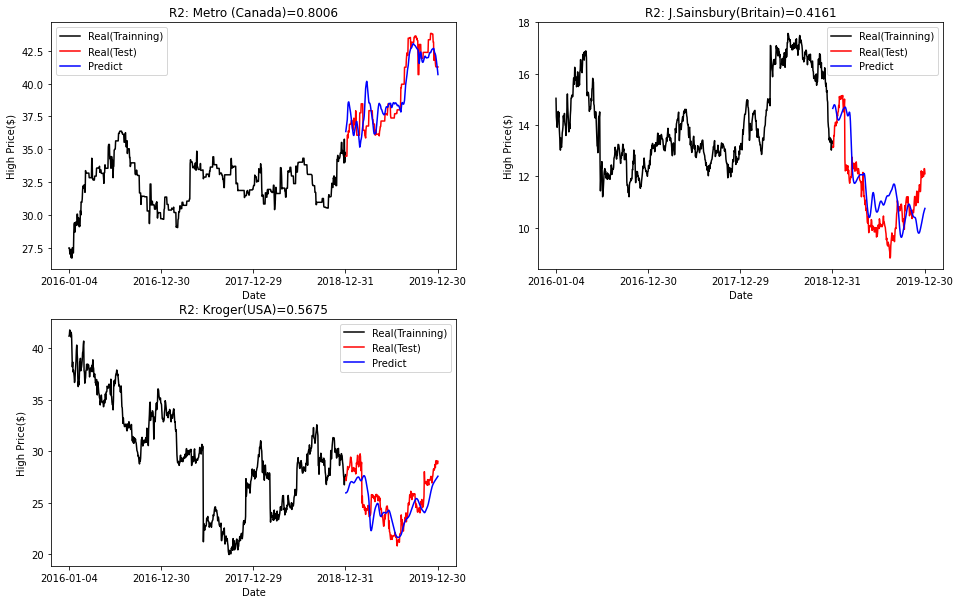

R2-3companies_average=0.5947

[Arguments]
num_company=3社 ['Carrefour(France)', 'Kroger(USA)', 'Coop Group (Switzerland)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(3, 754, 1), test_data=(3, 252, 1)
SECTOR2
SECTOR2-2
X_train=(694, 60, 3), y_trains=(2082,)
y_trains2=(3, 694)
1/3
Epoch 1/50
22/22 [==============================] - 12s 219ms/step - loss: 0.4544
Epoch 2/50
22/22 [==============================] - 5s 217ms/step - loss: 0.1286
Epoch 3/50
22/22 [==============================] - 5s 216ms/step - loss: 0.0944
Epoch 4/50
22/22 [==============================] - 5s 217ms/step - loss: 0.0820
Epoch 5/50
22/22 [==============================] - 5s 217ms/step - loss: 0.0870
Epoch 6/50
22/22 [==============================] - 5s 219ms/step - loss: 0.0746
Epoch 7/50
22/22 [==============================] - 5s 215ms/step - loss: 0.0732
Epoch 8/50
22/22 [========================

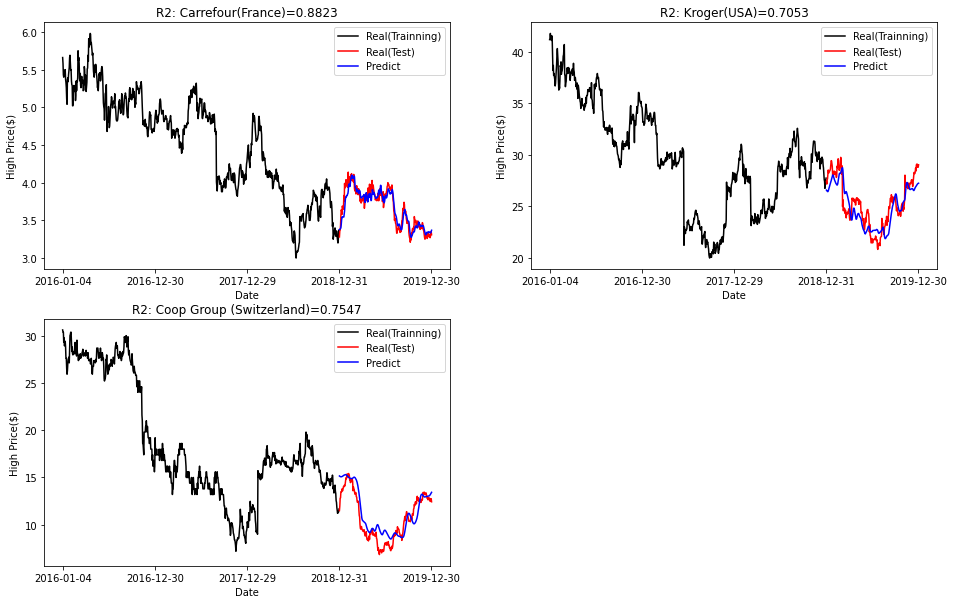

R2-3companies_average=0.7808

[Arguments]
num_company=3社 ['Metro (Canada)', 'AEON(Japan)', 'Seven & I Holdings (Japan)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(3, 754, 1), test_data=(3, 252, 1)
SECTOR2
SECTOR2-2
X_train=(694, 60, 3), y_trains=(2082,)
y_trains2=(3, 694)
1/3
Epoch 1/50
22/22 [==============================] - 12s 217ms/step - loss: 0.3937
Epoch 2/50
22/22 [==============================] - 5s 217ms/step - loss: 0.2086
Epoch 3/50
22/22 [==============================] - 5s 218ms/step - loss: 0.1494
Epoch 4/50
22/22 [==============================] - 5s 218ms/step - loss: 0.1368
Epoch 5/50
22/22 [==============================] - 5s 219ms/step - loss: 0.1327
Epoch 6/50
22/22 [==============================] - 5s 217ms/step - loss: 0.1133
Epoch 7/50
22/22 [==============================] - 5s 218ms/step - loss: 0.1237
Epoch 8/50
22/22 [=========================

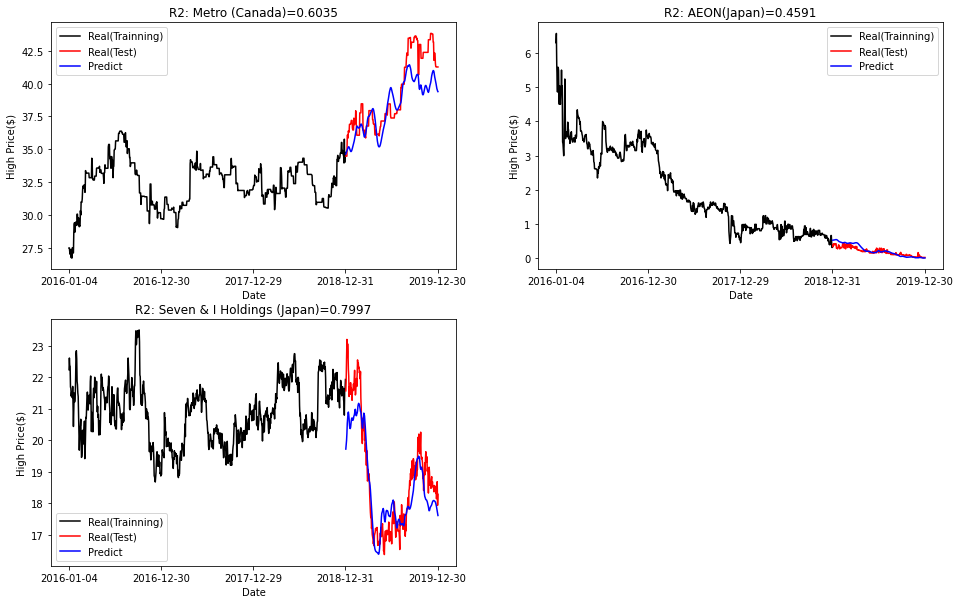

R2-3companies_average=0.6208



In [ ]:
# time_step=60, epochs=50, units=100
for i in range(10):
  all_in_all(all_data, num_company=3, input_num=[2], output_category=['High'], output_num=[2], outputs_company=3,
           train_size=754, time_step=60, epochs=50, units=100)

###Seven & I Holdings (Japan) 1社の例 

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout

In [ ]:
data = df1
data

,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume
0,0,2016-01-04,22.240000,22.809999,22.230000,22.790001,22.790001,385800
1,1,2016-01-05,22.610001,22.750000,22.480000,22.670000,22.670000,52600
2,2,2016-01-06,22.370001,22.520000,22.209999,22.389999,22.389999,66000
3,3,2016-01-07,22.350000,22.629999,22.150000,22.629999,22.629999,49900
4,4,2016-01-08,21.690001,22.030001,21.510000,21.570000,21.570000,69000
...,...,...,...,...,...,...,...,...
1001,1001,2019-12-24,18.150000,18.430000,18.150000,18.379999,18.379999,29000
1002,1002,2019-12-26,18.280001,18.370001,18.280001,18.299999,18.299999,50500
1003,1003,2019-12-27,18.690001,18.690001,18.280001,18.389999,18.389999,55100
1004,1004,2019-12-30,17.940001,18.290001,17.940001,18.230000,18.230000,70900


In [ ]:
data["Close"]=pd.to_numeric(data.Close,errors='coerce') #turning the Close column to numeric
data = data.dropna() #romeving the NA values
trainData = data.iloc[:,4:5].values #selecting only the closing prices for training
trainData.shape

(1006, 1)

In [ ]:
sc = MinMaxScaler(feature_range=(0,1))
trainData = sc.fit_transform(trainData)
trainData.shape

(1006, 1)

In [ ]:
X_train = []
y_train = []

for i in range (60, 946): #60 : timestep // 1149 : length of the data
    X_train.append(trainData[i-60:i,0]) 
    y_train.append(trainData[i,0])

X_train,y_train = np.array(X_train),np.array(y_train)
y_train.shape

(886,)

In [ ]:
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1)) #adding the batch_size axis
X_train.shape

(886, 60, 1)

In [ ]:
model = Sequential()

model.add(LSTM(units=100, return_sequences = True, input_shape =(X_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = False))
model.add(Dropout(0.2))

model.add(Dense(units =1))
model.compile(optimizer='adam', loss="mean_squared_error")

In [ ]:
hist = model.fit(X_train, y_train, epochs = 20, batch_size = 32)

Epoch 1/20
28/28 - 13s - loss: 0.0448
Epoch 2/20
28/28 - 5s - loss: 0.0128
Epoch 3/20
28/28 - 5s - loss: 0.0112
Epoch 4/20
28/28 - 5s - loss: 0.0110
Epoch 5/20
28/28 - 5s - loss: 0.0092
Epoch 6/20
28/28 - 6s - loss: 0.0084
Epoch 7/20
28/28 - 5s - loss: 0.0092
Epoch 8/20
28/28 - 5s - loss: 0.0099
Epoch 9/20
28/28 - 5s - loss: 0.0089
Epoch 10/20
28/28 - 5s - loss: 0.0088
Epoch 11/20
28/28 - 5s - loss: 0.0083
Epoch 12/20
28/28 - 5s - loss: 0.0075
Epoch 13/20
28/28 - 5s - loss: 0.0087
Epoch 14/20
28/28 - 5s - loss: 0.0074
Epoch 15/20
28/28 - 5s - loss: 0.0069
Epoch 16/20
28/28 - 5s - loss: 0.0069
Epoch 17/20
28/28 - 5s - loss: 0.0063
Epoch 18/20
28/28 - 5s - loss: 0.0064
Epoch 19/20
28/28 - 5s - loss: 0.0066
Epoch 20/20
28/28 - 5s - loss: 0.0063


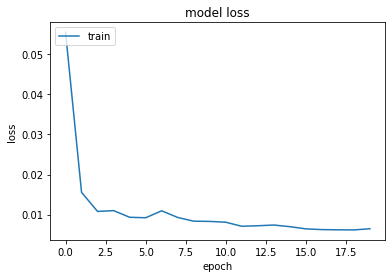

In [ ]:
plt.plot(hist.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
testData = df1 #importing the test data
testData["Close"]=pd.to_numeric(testData.Close,errors='coerce') #turning the close column to numerical type
testData = testData.dropna() #droping the NA values
testData = testData.iloc[:,4:5] #selecting the closing prices for testing
y_test = testData.iloc[60:,0:].values #selecting the labels 
#input array for the model
inputClosing = testData.iloc[:,0:].values 
inputClosing_scaled = sc.transform(inputClosing)
inputClosing_scaled.shape
X_test = []
length = len(testData)
timestep = 60
for i in range(timestep, length): #doing the same preivous preprocessing 
    X_test.append(inputClosing_scaled[i-timestep:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
X_test.shape

(946, 60, 1)

In [ ]:
y_pred = model.predict(X_test) #predicting the new values

In [ ]:
predicted_price = sc.inverse_transform(y_pred) #inversing the scaling transformation for ploting

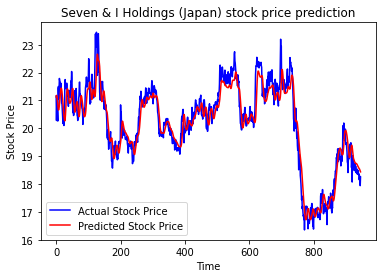

In [ ]:
plt.plot(y_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(predicted_price, color = 'red', label = 'Predicted Stock Price')
plt.title('Seven & I Holdings (Japan) stock price prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()